
### Persuasiveness Scoring

This notebook explores the development of a continuous persuasiveness scorer [0,1] that measures semantic alignment between image and text (tweets). Our dataset includes tweets paired with images, but thoses images can be persuasive or not (support the stance of the final argument of the tweet), our idea is that instead of using all images (with their text) we are going to filter/weight images based on their persuasiveness and then pass it to the final model. In this way, the model will only receive usefull information instead of images that could just add noise (ex. an image full white or ambigious)

Research Questions:
  1. Can CLIP zero-shot predict persuasiveness without training?
  2. Does fine-tuning CLIP improve persuasiveness detection?
  3. Does BLIP-2 outperform CLIP for this task?
  4. What threshold/weighting should we use in multimodal fusion?

Output:
  - Persuasiveness score [0, 1] for each (image, text) pair
  - Correlation analysis with ground truth labels
  - Conclusion and recommendation for multimodal fusion strategy

In [ ]:
# Libraries

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score,precision_recall_curve, roc_curve,f1_score, accuracy_score
from scipy.stats import pearsonr, spearmanr
from tqdm.auto import tqdm
from transformers import CLIPModel, CLIPProcessor, get_cosine_schedule_with_warmup, Blip2Model, Blip2Processor
from PIL import Image

import warnings
warnings.filterwarnings('ignore')



# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Seed:  {SEED}")
print(f"Using device: {device}")

Seed:  42
Using device: cuda


In [2]:
#Paths
DATA_PATH = "../../../data/"
IMG_PATH = "../../../data/images"
OUTPUT_DIR = "../../../experiments/vision/contrastive_persuasiveness/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_path = os.path.join(DATA_PATH,"train.csv")
dev_path   = os.path.join(DATA_PATH,"dev.csv")
test_path  = os.path.join(DATA_PATH,"test.csv")

#Load Data
df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)
    df["persuasiveness_label"] = df["persuasiveness"].map(pers_2id)


print(f"\n Train label distribution:")
print(f"\n Stance: \n Oppose: {(df_train['label']==0).sum()}\n Support: {(df_train['label']==1).sum()}")
print(f"\n\n  Persuasiveness \n No: {(df_train['persuasiveness_label']==0).sum()}\n Yes: {(df_train['persuasiveness_label']==1).sum()}")
df_train.head()



 Train label distribution:

 Stance: 
 Oppose: 1095
 Support: 719


  Persuasiveness 
 No: 1285
 Yes: 529


,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,label,persuasiveness_label
0,1148501065308004357,https://t.co/VQP1FHaWAg,Let's McGyver some Sanity in America!\n\nYou a...,support,no,train,1,0
1,1103872992537276417,https://t.co/zsyXYSeBkp,A child deserves a chance at life. A child des...,oppose,no,train,0,0
2,1151528583623585794,https://t.co/qSWvDX5MnM,"Dear prolifers: girls as young as 10, 11, 12 a...",support,no,train,1,0
3,1100166844026109953,https://t.co/hxH8tFIHUu,The many States will attempt to amend their co...,support,no,train,1,0
4,1021830413550067713,https://t.co/5whvEEtoQR,"Every #abortion is wrong, no matter what metho...",oppose,yes,train,0,1


### Multimodal Models

Why these models?

1. CLIP (Contrastive Language–Image Pretraining)
- Architecture: Dual-encoder model (ViT + Text Transformer) trained with a large-scale contrastive loss.
- Training: Learned to align images and text by maximizing similarity of paired samples.
- Relevance: It provides a strong baseline for pure semantic similarity. It's useful for measuring alignment and detect relevant/irrelevant images based on context.


2. BLIP-2 (Bootstrapped Language–Image Pretraining)
- Architecture: Vision encoder + Q-Former + Large Language Model (Flan-T5/OPT) that bridges visual features into a reasoning-capable LLM.
- Training: Combines contrastive pretraining with instruction tuning, enabling deeper multimodal understanding.
- Relevance: Captures the semantic support, reasoning about whether an image reinforces the meaning or stance of the tweet. This is critical for estimating persuasiveness beyond simple similarity.

### CLIP Zero-Shot (Baseline)

General Strategy: We use CLIP (No training) encode images and texts, and compute cosine similarity between embeddings. Use that similarity as persuasiveness socre [0,1] and evaluate: High similarity -> persuasiveness=1 (yes)?

In [3]:
#Training Hyperparameters and setup
BATCH_SIZE = 16  
NUM_WORKERS = 1  

# Thresholds
SIMILARITY_THRESHOLDS = np.arange(0.0, 1.0, 0.05)  

In [4]:
# Load CLIP model
CLIP = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(CLIP).to(device)
clip_processor = CLIPProcessor.from_pretrained(CLIP, use_fast=True)
print(f"Clip model loaded: {CLIP}")

Clip model loaded: openai/clip-vit-base-patch32


In [5]:
# Dataset just for CLIP
class ImageTextDatasetCLIP(Dataset):
    """
    Dataset for CLIP baseline: returns raw image + raw text + labels.
    Text is NOT tokenized here (done later in collate_fn).
    """
    
    def __init__(self, dataframe: pd.DataFrame, image_dir: str, processor):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.processor = processor 

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.image_dir, f"{row['tweet_id']}.jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color=(0, 0, 0))
            print(f"Warning: could not load image {img_path}. Using blank image instead.")

        text = str(row["tweet_text"])
        persuasiveness = torch.tensor(row["persuasiveness_label"], dtype=torch.float32)
        stance = torch.tensor(row["label"], dtype=torch.long)

        return {
            "image": image,
            "text": text,
            "persuasiveness": persuasiveness,
            "stance": stance,
            "tweet_id": row["tweet_id"],
        }


def custom_collate_fn_clip(batch):

    # Text Batch processing
    texts = [item["text"] for item in batch]
    text_inputs = clip_processor(text=texts, return_tensors="pt", padding=True, truncation=True,max_length=77)

    # Image batch processing
    images = [item["image"] for item in batch]   
    pixel_values = clip_processor(images=images, return_tensors="pt")["pixel_values"]

    persuasiveness = torch.stack([item["persuasiveness"] for item in batch])
    stance = torch.stack([item["stance"] for item in batch])
    tweet_ids = [item["tweet_id"] for item in batch]

    return {
        "pixel_values": pixel_values,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "persuasiveness": persuasiveness,
        "stance": stance,
        "text": texts,
        "tweet_id": tweet_ids,
    }


In [6]:
# Load CLIP model
clip_model = CLIPModel.from_pretrained(CLIP).to(device)
clip_processor = CLIPProcessor.from_pretrained(CLIP,use_fast=True)
print(f"Clip model loaded: {CLIP}")

# We create our dataset
clip_test_dataset = ImageTextDatasetCLIP(df_test, IMG_PATH, clip_processor)
clip_test_loader = DataLoader(clip_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=custom_collate_fn_clip)

# Function to compute CLIP similarities
def compute_clip_similarities(model, dataloader, device):
    
    model.eval()
    
    all_similarities = []
    all_labels = []
    all_texts = []
    all_tweet_ids = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing CLIP similarities"):
            # Move to device
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Get Visual Embeddings (Projection Space)
            image_embeds = model.get_image_features(pixel_values=pixel_values)

            # Get Text Embeddings (Projection Space)
            text_embeds = model.get_text_features(input_ids=input_ids,attention_mask=attention_mask)

            # Normalize embeddings
            image_embeds = F.normalize(image_embeds, p=2, dim=1)
            text_embeds = F.normalize(text_embeds, p=2, dim=1)
            
            # Compute cosine similarity!
            similarities = (image_embeds * text_embeds).sum(dim=1)  # [batch]
            
            # Since similarities are in [-1, 1], we convert them to [0,1] summing 1d dividing by 2
            similarities = (similarities + 1) / 2
            
            all_similarities.extend(similarities.cpu().numpy())
            all_labels.extend(batch['persuasiveness'].numpy())
            all_texts.extend(batch['text'])
            all_tweet_ids.extend(batch['tweet_id'])
    
    return (np.array(all_similarities), # similarities 0,1
            np.array(all_labels), # persuasiveness labels
            all_texts, # tweets
            all_tweet_ids) # tweet ids

# Compute similarities
print("\n Computing CLIP (zero-shot) similarities on TEST set...")
similarities, labels, texts, tweet_ids = compute_clip_similarities(clip_model,clip_test_loader,device)

print(f"\n Computed {len(similarities)} similarity scores")
print(f"  Mean similarity: {similarities.mean():.4f}")
print(f"  Std similarity: {similarities.std():.4f}")
print(f"  Min similarity: {similarities.min():.4f}")
print(f"  Max similarity: {similarities.max():.4f}")

Clip model loaded: openai/clip-vit-base-patch32

 Computing CLIP (zero-shot) similarities on TEST set...


Computing CLIP similarities:   0%|          | 0/19 [00:00<?, ?it/s]


 Computed 300 similarity scores
  Mean similarity: 0.6456
  Std similarity: 0.0241
  Min similarity: 0.5733
  Max similarity: 0.7106


In [7]:
# We evaluate CLIP zero-shot as a persuasiveness predictor

# continious scores
auroc_baseline = roc_auc_score(labels, similarities)
ap_baseline = average_precision_score(labels, similarities) 

# Pearson and Spearman correlation
pearson_corr, pearson_p = pearsonr(similarities, labels)
spearman_corr, spearman_p = spearmanr(similarities, labels)

print(f"\n CLIP Zero-Shot Performance:")
print(f"  AUROC: {auroc_baseline:.4f}")
print(f"  Average Precision: {ap_baseline:.4f}")
print(f"  Pearson correlation: {pearson_corr:.4f} (p={pearson_p:.2e})")
print(f"  Spearman correlation: {spearman_corr:.4f} (p={spearman_p:.2e})")



 CLIP Zero-Shot Performance:
  AUROC: 0.5004
  Average Precision: 0.3518
  Pearson correlation: 0.0152 (p=7.93e-01)
  Spearman correlation: 0.0006 (p=9.91e-01)


In [8]:
# We will now find the optimal threshold for binary classification (persuasiveness yes/no)
best_f1 = 0
best_threshold = 0
threshold_results = []

for threshold in SIMILARITY_THRESHOLDS:
    predictions = (similarities >= threshold).astype(int)
    f1 = f1_score(labels, predictions, zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    threshold_results.append({'threshold': threshold,'f1': f1,'accuracy': acc})
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n Optimal threshold: {best_threshold:.2f}")
print(f"   F1 Score: {best_f1:.4f}")


 Optimal threshold: 0.60
   F1 Score: 0.5330



 CLIP Zero-Shot Performance (binary with threshold=0.60):
  Accuracy: 0.3867
  F1 Score: 0.5330


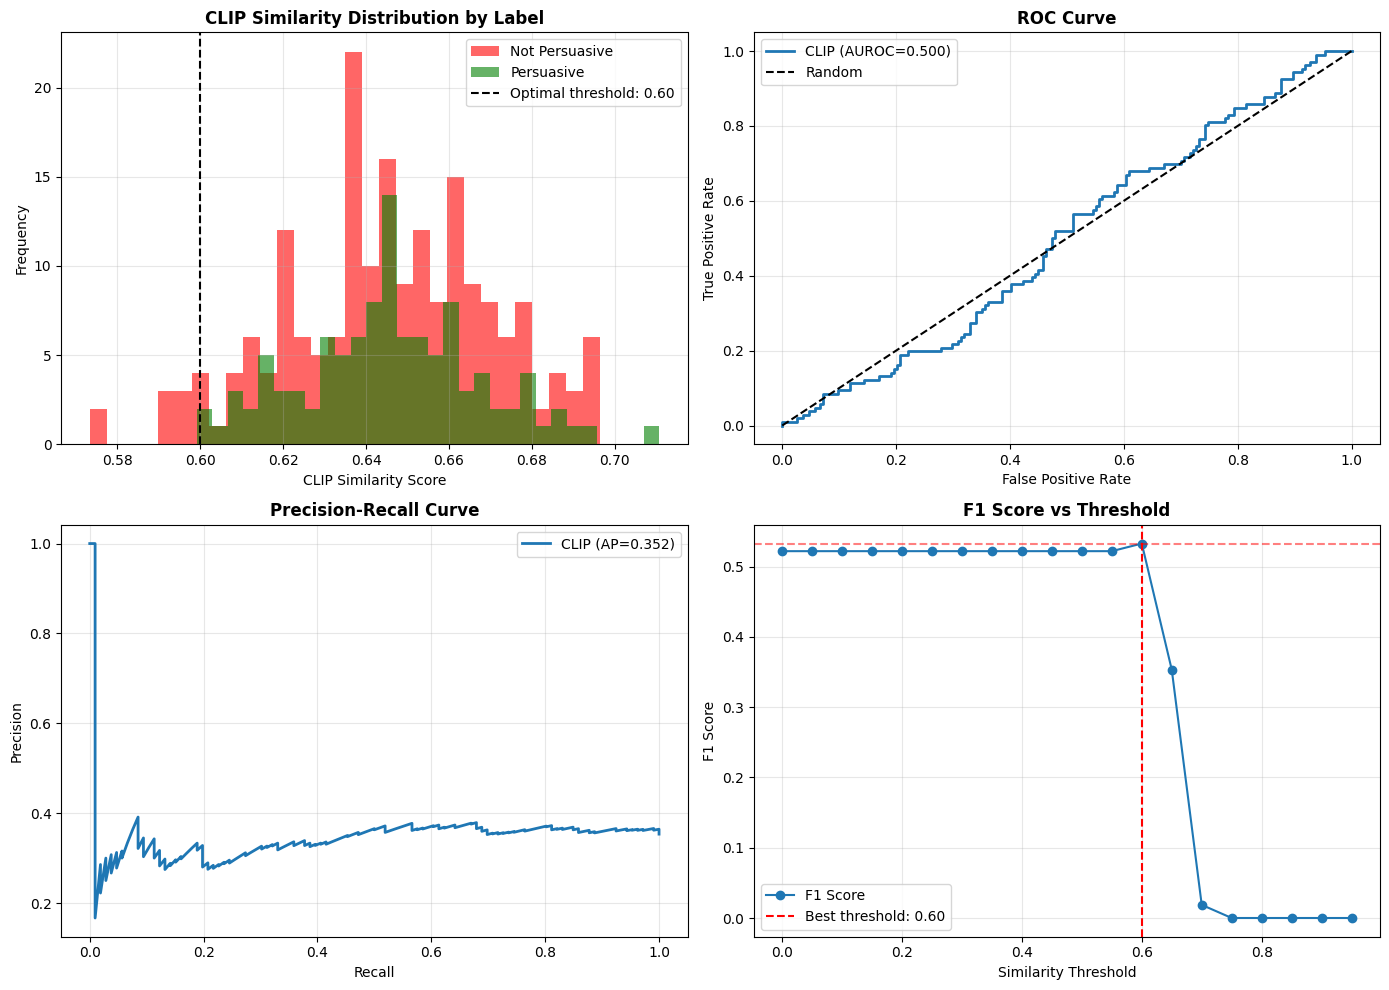

Predictions saved in ../../../experiments/vision/contrastive_persuasiveness/: clip_zeroshot_predictions.csv


In [9]:
# We predict with our optimal threshold
optimal_preds = (similarities >= best_threshold).astype(int)
optimal_acc = accuracy_score(labels, optimal_preds)

print(f"\n CLIP Zero-Shot Performance (binary with threshold={best_threshold:.2f}):")
print(f"  Accuracy: {optimal_acc:.4f}")
print(f"  F1 Score: {best_f1:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Similarity distribution by label
axes[0, 0].hist(similarities[labels == 0], bins=30, alpha=0.6, label='Not Persuasive', color='red')
axes[0, 0].hist(similarities[labels == 1], bins=30, alpha=0.6, label='Persuasive', color='green')
axes[0, 0].axvline(best_threshold, color='black', linestyle='--', label=f'Optimal threshold: {best_threshold:.2f}')
axes[0, 0].set_xlabel('CLIP Similarity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('CLIP Similarity Distribution by Label', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# ROC Curve
fpr, tpr, _ = roc_curve(labels, similarities)
axes[0, 1].plot(fpr, tpr, label=f'CLIP (AUROC={auroc_baseline:.3f})', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(labels, similarities)
axes[1, 0].plot(recall, precision, linewidth=2, label=f'CLIP (AP={ap_baseline:.3f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# F1 vs Threshold
threshold_df = pd.DataFrame(threshold_results)
axes[1, 1].plot(threshold_df['threshold'], threshold_df['f1'], marker='o', label='F1 Score')
axes[1, 1].axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
axes[1, 1].axhline(best_f1, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Similarity Threshold')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('F1 Score vs Threshold', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'clip_zeroshot_evaluation.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save results
results_df = pd.DataFrame({'tweet_id': tweet_ids,'text': texts,'similarity_score': similarities,'persuasiveness_true': labels,'persuasiveness_pred': optimal_preds})
results_df.to_csv(os.path.join(OUTPUT_DIR, 'clip_zeroshot_predictions.csv'), index=False)
print(f"Predictions saved in {OUTPUT_DIR}: clip_zeroshot_predictions.csv")


#### Performance Analysis 

- Based on our AUROC close to $0.49$, our F1-Score $0.53$ we conclude that our model cannot distinguish between a pair (image, tweet) that is persuasive (relevant) and one that is not, based only on cosine similarity. It's equivalent to flipping a coing.
- Our correlations, both Pearson and Spearman, are close to $0$ (with $p$ values high) confirm that there is no linear relationship between the CLIP similarity score and our persuasiveness label.

This resultus were expected since CLIP measures a broad semantic similarity. An example: A tweet about gun control (text) may have an image of a beautiful landscape (image), CLIP can give a decent score if the text mentions "freedom" or "country",  and associates semantically those concepts. CLIP is not trained to understand this level of argumentative cohesion. 

## CLIP Fine-Tuned with Binary Loss

General idea: We pull together embeddings of persuasive (image, text), and we push apart embeddings of non-persuasive pairs. For persuasive pairs: maximize cosine similarity, for non-persuasive pairs: minimize cosine similarity. This should improve the previous CLIP Score because it's align to our specific domain (Gun Control / Abortion)

In [ ]:
class CLIPPersuasivenessModel(nn.Module):

    def __init__(
        self,
        clip_model_name: str = "openai/clip-vit-base-patch32",
        freeze_encoders: bool = True,
        num_layers_to_finetune: int = 1,
        use_mlp_head: bool = True):
        
        super().__init__()
        
        # Load CLIP
        self.clip = CLIPModel.from_pretrained(clip_model_name)
        
        # Freeze / Partial Unfreeze---------------------------------------------------------
        TOTAL_LAYERS = 12 # CLIP
        # Freeze everything first
        for param in self.clip.parameters():
            param.requires_grad = False
        
        if not freeze_encoders:
            # Unfreeze last N transformer blocks in VISION
            vision_layers = self.clip.vision_model.encoder.layers
            for i, layer in enumerate(vision_layers):
                if i >= TOTAL_LAYERS - num_layers_to_finetune:
                    for p in layer.parameters():
                        p.requires_grad = True
                        
                # Unfreeze last N transformer blocks in TEXT
            text_layers = self.clip.text_model.encoder.layers
            for i, layer in enumerate(text_layers):
                if i >= TOTAL_LAYERS - num_layers_to_finetune:
                    for p in layer.parameters():
                        p.requires_grad = True
            
            # Unfreeze projection heads (VERY IMPORTANT)
            for p in self.clip.visual_projection.parameters():
                p.requires_grad = True
            for p in self.clip.text_projection.parameters():
                p.requires_grad = True

            freeze_encoders=str(f"Last {num_layers_to_finetune} layers of the encoders unfreezed for finetuning.")
        

        
        self.use_mlp_head = use_mlp_head

        #Comentario: Podríamos mejorar esta arquitectura
        if use_mlp_head:
            self.head = nn.Sequential(
                nn.Linear(512 + 512 + 1, 256),  # concat(img_emb, txt_emb, similarity)
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 1),
                nn.Sigmoid())
        
        print(f"    CLIP Persuasiveness Model initialized")
        print(f"     - Freeze encoders: {freeze_encoders}")
        print(f"     - Use MLP head: {use_mlp_head}")
    
    def forward(self, pixel_values, input_ids, attention_mask):

        # Get Visual Embeddings (Projection Space)
        image_embeds = self.clip.get_image_features(pixel_values=pixel_values)

        # Get Text Embeddings (Projection Space)
        text_embeds = self.clip.get_text_features(input_ids=input_ids,attention_mask=attention_mask)

        # Normalize
        img_features = F.normalize(image_embeds, p=2, dim=1)
        txt_features = F.normalize(text_embeds, p=2, dim=1)

        # Cosine similarity
        similarity = (img_features * txt_features).sum(dim=1)
        similarity_01 = (similarity + 1) / 2
        
        if self.use_mlp_head:
            features = torch.cat([img_features, txt_features, similarity_01.unsqueeze(1)], dim=1)
            mlp_score = self.head(features).squeeze(1)
            return similarity_01, mlp_score
        else:
            return similarity_01, similarity_01  # fallback

def train_clip_persuasiveness(model,train_loader,dev_loader,num_epochs=10,learning_rate=5e-6,weight_decay=1e-4,warmup_ratio=0.1,
    device=device):

    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    
    # Scheduler
    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = int(num_training_steps * warmup_ratio)
    scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps)
    
    best_auroc = 0
    best_model_state = None
    history = {'train_loss': [],
                'dev_auroc': [],
                  'dev_ap': []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training
        model.train()
        train_loss = 0
        
        pbar = tqdm(train_loader, desc="Training")
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['persuasiveness'].to(device)
            
            # Forward
            similarity, pred_score = model(pixel_values, input_ids, attention_mask)
            
            # Loss
            loss = F.binary_cross_entropy(pred_score, labels)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item() * pixel_values.size(0)
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        all_scores = []
        all_labels = []
        
        with torch.no_grad():
            for batch in tqdm(dev_loader, desc="Validation", leave=False):
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['persuasiveness']
                
                _, pred_score = model(pixel_values, input_ids, attention_mask)
                
                all_scores.extend(pred_score.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        all_scores = np.array(all_scores)
        all_labels = np.array(all_labels)
        
        auroc = roc_auc_score(all_labels, all_scores)
        ap = average_precision_score(all_labels, all_scores)
        
        history['train_loss'].append(train_loss)
        history['dev_auroc'].append(auroc)
        history['dev_ap'].append(ap)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Dev AUROC: {auroc:.4f} | Dev AP: {ap:.4f}")
        
        if auroc > best_auroc:
            best_auroc = auroc
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f" New best AUROC: {best_auroc:.4f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    model = model.to(device)
    
    print(f"\n Training complete! Best Dev AUROC: {best_auroc:.4f}")
    return model, history


In [11]:
#Training Hyperparameters and setup
BATCH_SIZE = 16  
NUM_EPOCHS = 13
LEARNING_RATE =  5e-6
WEIGHT_DECAY = 1e-4
WARMUP_RATIO = 0.1
NUM_WORKERS = 1  

In [12]:

# Create datasets
#Train
clip_train_dataset = ImageTextDatasetCLIP(df_train, IMG_PATH, clip_processor)
clip_train_loader = DataLoader(clip_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=custom_collate_fn_clip)

#Dev
clip_dev_dataset = ImageTextDatasetCLIP(df_dev, IMG_PATH, clip_processor)
clip_dev_loader = DataLoader(clip_dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=custom_collate_fn_clip)

# Initialize model
clip_finetuned_model = CLIPPersuasivenessModel(clip_model_name=CLIP,freeze_encoders=False)

# Train
clip_finetuned_model, clip_history = train_clip_persuasiveness(
    clip_finetuned_model,
    clip_train_loader,
    clip_dev_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    device=device)

# Evaluate on test set
print("\n Evaluating CLIP Fine-tuned on TEST set...")
clip_finetuned_model.eval()
finetuned_scores = []
finetuned_labels = []

with torch.no_grad():
    for batch in tqdm(clip_test_loader, desc="Testing"):
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        _, pred_score = clip_finetuned_model(pixel_values, input_ids, attention_mask)
        
        finetuned_scores.extend(pred_score.cpu().numpy())
        finetuned_labels.extend(batch['persuasiveness'].numpy())

finetuned_scores = np.array(finetuned_scores)
finetuned_labels = np.array(finetuned_labels)

# Metrics
finetuned_auroc_clip = roc_auc_score(finetuned_labels, finetuned_scores)
finetuned_ap_clip = average_precision_score(finetuned_labels, finetuned_scores)

print("\n\n\nCLIP FINE-TUNED TEST RESULTS")
print(f"AUROC: {finetuned_auroc_clip:.4f}")
print(f"Average Precision: {finetuned_ap_clip:.4f}")
print(f"\nComparison with Zero-Shot:")
print(f"  Zero-Shot AUROC: {auroc_baseline:.4f}")
print(f"  Fine-tuned AUROC: {finetuned_auroc_clip:.4f}")
print(f"  Improvement: {(finetuned_auroc_clip - auroc_baseline):.4f} ({((finetuned_auroc_clip/auroc_baseline - 1)*100):.1f}%)")

# Save model
torch.save(clip_finetuned_model.state_dict(), os.path.join(OUTPUT_DIR, 'clip_finetuned_persuasiveness.pth'))
print(f"model saved in {OUTPUT_DIR}: clip_finetuned_persuasiveness.pth")


    CLIP Persuasiveness Model initialized
     - Freeze encoders: Last 1 layers of the encoders unfreezed for finetuning.
     - Use MLP head: True

Epoch 1/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6870
Dev AUROC: 0.4915 | Dev AP: 0.3137
 New best AUROC: 0.4915

Epoch 2/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Loss: 0.6608
Dev AUROC: 0.5385 | Dev AP: 0.3467
 New best AUROC: 0.5385

Epoch 3/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.6346
Dev AUROC: 0.6420 | Dev AP: 0.4339
 New best AUROC: 0.6420

Epoch 4/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()
      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

   

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6205
Dev AUROC: 0.7335 | Dev AP: 0.5586
 New best AUROC: 0.7335

Epoch 5/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Loss: 0.6070
Dev AUROC: 0.7479 | Dev AP: 0.6006
 New best AUROC: 0.7479

Epoch 6/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.5908
Dev AUROC: 0.7518 | Dev AP: 0.6126
 New best AUROC: 0.7518

Epoch 7/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990><function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

   

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5758
Dev AUROC: 0.7568 | Dev AP: 0.6253
 New best AUROC: 0.7568

Epoch 8/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train Loss: 0.5617
Dev AUROC: 0.7584 | Dev AP: 0.6335
 New best AUROC: 0.7584

Epoch 9/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.5523
Dev AUROC: 0.7605 | Dev AP: 0.6384
 New best AUROC: 0.7605

Epoch 10/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

      File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    

Train Loss: 0.5450
Dev AUROC: 0.7616 | Dev AP: 0.6390
 New best AUROC: 0.7616

Epoch 11/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5411
Dev AUROC: 0.7625 | Dev AP: 0.6374
 New best AUROC: 0.7625

Epoch 12/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.5388
Dev AUROC: 0.7633 | Dev AP: 0.6387
 New best AUROC: 0.7633

Epoch 13/13


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.5389
Dev AUROC: 0.7632 | Dev AP: 0.6386

 Training complete! Best Dev AUROC: 0.7633

 Evaluating CLIP Fine-tuned on TEST set...


Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo




CLIP FINE-TUNED TEST RESULTS
AUROC: 0.7331
Average Precision: 0.5923

Comparison with Zero-Shot:
  Zero-Shot AUROC: 0.5004
  Fine-tuned AUROC: 0.7331
  Improvement: 0.2327 (46.5%)
model saved in ../../../experiments/vision/contrastive_persuasiveness/: clip_finetuned_persuasiveness.pth


### BLIP-2 Fine-Tuned with Binary Loss

General idea: We'll fine-tune BLIP-2 for persuasiveness scoring, same as CLIP but BLIP it's more recent than CLIP (2023), uses Q-former ( with cross-Attention, so both embeddings learn from each other and from themselves) to bridge vision and language, it's supposely better at complex visual reasoning and since we have memes could perform better.

In [14]:
# Our BLIP2 Model
BLIP2 = "Salesforce/blip2-opt-2.7b"

In [15]:
# Load model
blip2_processor = Blip2Processor.from_pretrained(BLIP2,use_fast=True)
blip2_model = Blip2Model.from_pretrained(BLIP2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
class BLIP2Dataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, image_dir: str, processor):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.processor = processor 
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.image_dir, f"{row['tweet_id']}.jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color=(0, 0, 0))
            print(f"Warning: could not load image {img_path}. Using blank image instead.")
        
        # Get text
        text = str(row['tweet_text'])
        
        # Get Persuasiveness label
        persuasiveness = row["persuasiveness_label"]

        # Get Stance Label
        stance = row["label"]
        
        return {
            "image": image,
            "text": text,
            "persuasiveness": persuasiveness,
            "stance": stance,
            "tweet_id": str(row["tweet_id"])
        }

def blip2_collate_fn(batch):
    """
    Collate function for BLIP-2.
    
    IMPORTANTE: Procesar imagen + texto JUNTOS con processor.
    """
    images = [item["image"] for item in batch]
    texts = [item["text"] for item in batch]
    persuasiveness = torch.tensor([item["persuasiveness"] for item in batch], dtype=torch.float32)
    tweet_ids = [item["tweet_id"] for item in batch]
    
    # Process together (critical for BLIP-2 alignment)
    encoded = blip2_processor(
        images=images,
        text=texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGHT,  # Based on our tweets length 
        return_tensors="pt")
    
    return {
        "pixel_values": encoded["pixel_values"],
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "persuasiveness": persuasiveness,
        "tweet_id": tweet_ids}

In [17]:
class BLIP2PersuasivenessModel(nn.Module):
    """
    BLIP-2 para persuasiveness scoring.
    
    Solo usa Vision Encoder + Q-Former (NO Language Model).
    """
    
    def __init__(self, 
                 blip_model_name="Salesforce/blip2-opt-2.7b", 
                 freeze_encoders: bool = True,
                 num_layers_to_finetune: int = 1,
                 use_mlp_head: bool = True):
        
        super().__init__()
        
        self.freeze_encoders = freeze_encoders

        # Load BLIP-2 model
        self.blip2 = Blip2Model.from_pretrained(blip_model_name)
        
   

         # Freeze / Partial Unfreeze---------------------------------------------------------
        # Freeze everything first
        for param in self.blip2.parameters():
            param.requires_grad = False


        if not freeze_encoders:            
            # Vision encoder
            total_vision_layers = len(self.blip2.vision_model.encoder.layers)
            for i, layer in enumerate(self.blip2.vision_model.encoder.layers):
                if i >= total_vision_layers - num_layers_to_finetune:
                    for p in layer.parameters():
                        p.requires_grad = True
                        
            # QFormer encoder
            total_qformer_layers = len(self.blip2.qformer.encoder.layer)
            for i, layer in enumerate(self.blip2.qformer.encoder.layer):
                if i >= total_qformer_layers - num_layers_to_finetune:
                    for p in layer.parameters():
                        p.requires_grad = True
            
            freeze_encoders=str(f"Last {num_layers_to_finetune} layers of the encoders unfreezed for finetuning.")
        
        # Get hidden dimension from Q-Former
        hidden_dim = self.blip2.config.qformer_config.hidden_size  # 768
        
        # Classification head
        if use_mlp_head:
            self.head = nn.Sequential(
                nn.Linear(hidden_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 1),
                nn.Sigmoid())
        
        print(f"   BLIP-2 Persuasiveness Model initialized")
        print(f" - Freeze encoders: {freeze_encoders}")
        print(f" - Use MLP head: {use_mlp_head}")
    
    
    def forward(self, pixel_values, input_ids=None, attention_mask=None):
        
        
        # Get Q-Former outputs with text and image together (AS BLIP expects)
        outputs = self.blip2(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        if self.freeze_encoders:
            qformer_output = outputs.qformer_outputs.pooler_output # pooler_output more stable if we dont finetune besides the head.
        else:
            qformer_output = outputs.qformer_outputs.last_hidden_state[:, 0, :] #Use the last token hidden state then do pooling

        
        # Classification
        score = self.head(qformer_output).squeeze(1)  # [batch]
        
        return score
    
def get_embeddings(self, pixel_values, input_ids=None, attention_mask=None):
    with torch.no_grad():
        outputs = self.blip2(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )

        # As the forward
        if self.freeze_encoders:
            qformer_output = outputs.qformer_outputs.pooler_output
        else:
            qformer_output = outputs.qformer_outputs.last_hidden_state[:, 0, :]
    
    return qformer_output



In [56]:
def train_blip_persuasiveness(model, 
                              train_loader, 
                              dev_loader, 
                              num_epochs=5, 
                              learning_rate=3e-5, 
                              weight_decay=1e-2,
                              warmup_ratio=0.1,
                              device=device):

    model = model.to(device)

    # Solo entrenamos la cabeza si freeze_encoders=True
    if model.freeze_encoders:
        params_to_train = list(model.head.parameters())
        optimizer = torch.optim.AdamW(model.head.parameters(), lr=learning_rate, weight_decay=weight_decay)
        print("Training only classification head")
    else:
        # Fine-tuning parcial: entrenamos head + capas descongeladas
        params_to_train = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(params_to_train, lr=learning_rate, weight_decay=weight_decay)
        print("Training classification head + unfrozen encoder layers")

    # Scheduler
    num_training_steps = len(train_loader) * num_epochs
    num_warmup_steps = int(num_training_steps * warmup_ratio)
    scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=num_warmup_steps,num_training_steps=num_training_steps)
    

    best_auroc = 0
    best_model_state = None
    history = {"train_loss": [],
               "dev_auroc": [],
               'dev_ap': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # -------- Training --------
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc="Training"):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['persuasiveness'].to(device)
            
            # Forward
            pred = model(pixel_values=pixel_values,input_ids=input_ids,attention_mask=attention_mask)
            
            # Loss
            loss = F.binary_cross_entropy(pred, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params_to_train, 1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * pixel_values.size(0)

        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # Validation
        model.eval()
        dev_scores = []
        dev_labels = []

        with torch.no_grad():
            for batch in tqdm(dev_loader, desc="Validation", leave=False):
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch.get('input_ids', None)
                attention_mask = batch.get('attention_mask', None)
                if input_ids is not None:
                    input_ids = input_ids.to(device)
                if attention_mask is not None:
                    attention_mask = attention_mask.to(device)

                preds = model(pixel_values, input_ids, attention_mask)

                dev_scores.extend(preds.cpu().numpy())
                dev_labels.extend(batch['persuasiveness'].numpy())

        dev_scores = np.array(dev_scores)
        dev_labels = np.array(dev_labels)

        dev_auroc = roc_auc_score(dev_labels, dev_scores)
        dev_ap = average_precision_score(dev_labels, dev_scores)

        history['dev_auroc'].append(dev_auroc)
        history['dev_ap'].append(dev_ap)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Dev AUROC: {dev_auroc:.4f} | Dev AP: {dev_ap:.4f}")
        
        if dev_auroc > best_auroc:
            best_auroc = dev_auroc
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f" New best AUROC: {best_auroc:.4f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    model = model.to(device)

    print(f"\n  Training complete! Best Dev AUROC: {best_auroc:.4f}")
    return model, history

In [ ]:
#Parameters and Setup
BATCH_SIZE = 16
NUM_WORKERS= 2
MAX_LENGHT = 105  #Based on our tweets lenght
NUM_EPOCHS=4
WEIGHT_DECAY=1e-2

#We unfreeze some layers?
FREEZE_ENCODERS=False

#Q-Former is very sensinble we want a lower LR / How many layers we finetune?
if FREEZE_ENCODERS:
    LEARNING_RATE=1e-4
else:
    LEARNING_RATE=3e-5
    NUM_LAYERS_FINE=1

In [61]:
#We train BLIP-2 for persuasiveness prediction

# Create BLIP-2 datasets

#Train
blip2_train_dataset = BLIP2Dataset(df_train, IMG_PATH, blip2_processor)
blip2_train_loader = DataLoader(blip2_train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=blip2_collate_fn)

#Dev
blip2_dev_dataset = BLIP2Dataset(df_dev, IMG_PATH, blip2_processor)
blip2_dev_loader = DataLoader(blip2_dev_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=blip2_collate_fn)


#Test
blip2_test_dataset = BLIP2Dataset(df_test, IMG_PATH, blip2_processor)
blip2_test_loader = DataLoader(blip2_test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=blip2_collate_fn)


# Initialize model
blip_finetuned_model = BLIP2PersuasivenessModel(blip_model_name=BLIP2,freeze_encoders=FREEZE_ENCODERS,num_layers_to_finetune=NUM_LAYERS_FINE)
print(f"Total parameters: {sum(p.numel() for p in blip_finetuned_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in blip_finetuned_model.parameters() if p.requires_grad):,}")


#Train
print(f"\n\n  Finetuning BLIP-2: \nEPOCHS:{NUM_EPOCHS}\nBATCH_SIZE:{BATCH_SIZE}\nLEARNING RATE:{LEARNING_RATE}\nWEIGHT_DECAY:{WEIGHT_DECAY}")
blip_finetuned_model, blip_history = train_blip_persuasiveness(blip_finetuned_model,
                                                               blip2_train_loader, 
                                                               blip2_dev_loader,
                                                               num_epochs=NUM_EPOCHS,
                                                               learning_rate=LEARNING_RATE,
                                                               weight_decay=WEIGHT_DECAY,
                                                               device=device)


# Evaluate on test set
print("\n Evaluating BLIP Fine-tuned on TEST set...")
blip_finetuned_model.eval()
finetuned_scores = []
finetuned_labels = []

with torch.no_grad():
    for batch in tqdm(blip2_test_loader, desc="Testing"):
        
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        pred_score = blip_finetuned_model(pixel_values, input_ids, attention_mask)
        
        finetuned_scores.extend(pred_score.cpu().numpy())
        finetuned_labels.extend(batch['persuasiveness'].numpy())

finetuned_scores = np.array(finetuned_scores)
finetuned_labels = np.array(finetuned_labels)

# Metrics
finetuned_auroc_blip = roc_auc_score(finetuned_labels, finetuned_scores)
finetuned_ap_blip = average_precision_score(finetuned_labels, finetuned_scores)

print("\n\n\nBLIP FINE-TUNED TEST RESULTS")
print(f"AUROC: {finetuned_auroc_blip:.4f}")
print(f"Average Precision: {finetuned_ap_blip:.4f}")
print(f"\nComparison with Zero-Shot:")
print(f"  Zero-Shot AUROC: {auroc_baseline:.4f}")
print(f"  Fine-tuned AUROC: {finetuned_auroc_blip:.4f}")
print(f"  Improvement: {(finetuned_auroc_blip - auroc_baseline):.4f} ({((finetuned_auroc_blip/auroc_baseline - 1)*100):.1f}%)")
print(f"\nComparison with CLIP:")
print(f"  CLIP AUROC: {finetuned_auroc_clip:.4f}")
print(f"  BLIP AUROC: {finetuned_auroc_blip:.4f}")
print(f"  Improvement: {(finetuned_auroc_blip - finetuned_auroc_clip):.4f} ({((finetuned_auroc_blip/finetuned_auroc_clip - 1)*100):.1f}%)")

# Save model
torch.save(blip_finetuned_model.state_dict(), os.path.join(OUTPUT_DIR, 'blip_finetuned_persuasiveness.pth'))
print(f"model saved in {OUTPUT_DIR}: blip_finetuned_persuasiveness.pth")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   BLIP-2 Persuasiveness Model initialized
 - Freeze encoders: Last 1 layers of the encoders unfreezed for finetuning.
 - Use MLP head: True
Total parameters: 3,744,958,977
Trainable parameters: 32,535,169


  Finetuning BLIP-2: 
EPOCHS:4
BATCH_SIZE:16
LEARNING RATE:3e-05
WEIGHT_DECAY:0.01
Training classification head + unfrozen encoder layers

Epoch 1/4


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5942
Dev AUROC: 0.7665 | Dev AP: 0.5744
 New best AUROC: 0.7665

Epoch 2/4


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
Exception ignored in:   File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.5039
Dev AUROC: 0.7946 | Dev AP: 0.5876
 New best AUROC: 0.7946

Epoch 3/4


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fde84201990>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

Train Loss: 0.4233
Dev AUROC: 0.8061 | Dev AP: 0.6331
 New best AUROC: 0.8061

Epoch 4/4


Training:   0%|          | 0/114 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.3493
Dev AUROC: 0.8104 | Dev AP: 0.6418
 New best AUROC: 0.8104

  Training complete! Best Dev AUROC: 0.8104

 Evaluating BLIP Fine-tuned on TEST set...


Testing:   0%|          | 0/19 [00:00<?, ?it/s]




BLIP FINE-TUNED TEST RESULTS
AUROC: 0.7542
Average Precision: 0.6179

Comparison with Zero-Shot:
  Zero-Shot AUROC: 0.5004
  Fine-tuned AUROC: 0.7542
  Improvement: 0.2538 (50.7%)

Comparison with CLIP:
  CLIP AUROC: 0.7331
  BLIP AUROC: 0.7542
  Improvement: 0.0211 (2.9%)
model saved in ../../../experiments/vision/contrastive_persuasiveness/: blip_finetuned_persuasiveness.pth


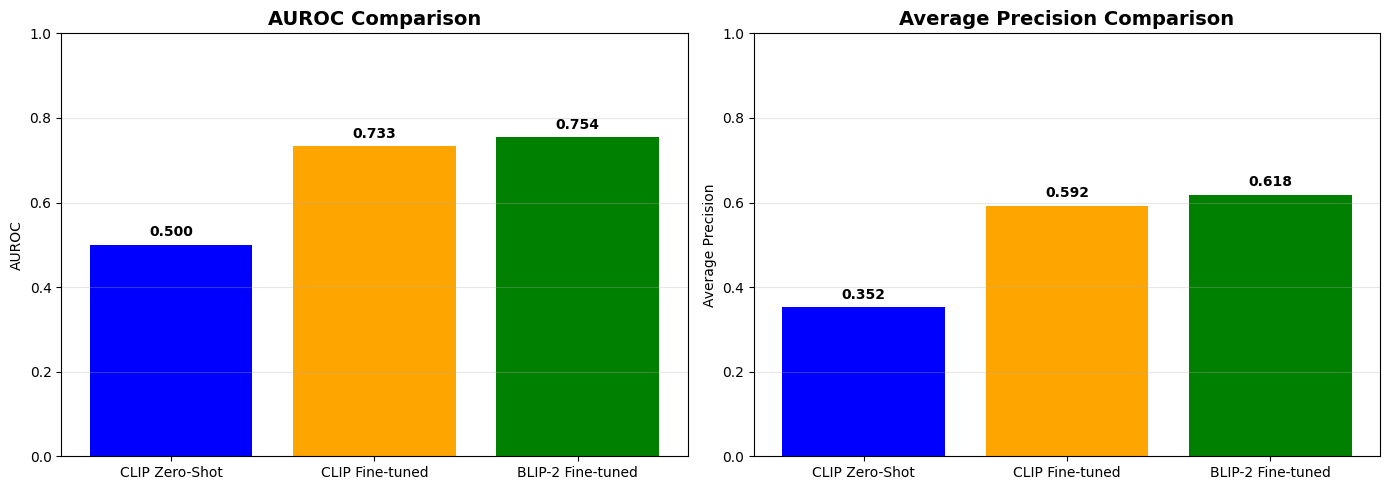

In [62]:
# Final Comparision between models
comparison = pd.DataFrame({
    'Model': ['CLIP Zero-Shot', 'CLIP Fine-tuned', 'BLIP-2 Fine-tuned'],
    'AUROC': [auroc_baseline, finetuned_auroc_clip, finetuned_auroc_blip],
    'Average Precision': [ap_baseline, finetuned_ap_clip, finetuned_ap_blip],
    'Inference Speed': ['Fast', 'Fast', 'Slow']})


# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUROC comparison
axes[0].bar(comparison['Model'], comparison['AUROC'], color = ["blue", "orange", "green"])
axes[0].set_title('AUROC Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('AUROC')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, row in comparison.iterrows():
    axes[0].text(i, row['AUROC'] + 0.02, f"{row['AUROC']:.3f}", ha='center', fontweight='bold')

# AP comparison
axes[1].bar(comparison['Model'], comparison['Average Precision'], color =["blue", "orange", "green"])
axes[1].set_title('Average Precision Comparison', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Average Precision')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, row in comparison.iterrows():
    axes[1].text(i, row['Average Precision'] + 0.02, f"{row['Average Precision']:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'final_comparison.png'), bbox_inches='tight')
plt.show()

In [63]:
#  Concluson: Best Model
best_model = comparison.loc[comparison['AUROC'].idxmax(), 'Model']
best_auroc = comparison['AUROC'].max()
best_ap = comparison['Average Precision'].max()

print(f"\n Best Model: {best_model} with AUROC={best_auroc:.4f} and Average Precision={best_ap:.4f}")


 Best Model: BLIP-2 Fine-tuned with AUROC=0.7542 and Average Precision=0.6179


### Persuasiveness Scoring Analysis

- **Model Performance**

| Model | AUROC | AP | Interpretation |
|-------|-------|----|----------------|
| CLIP Baseline | 0.50 | 0.35 | Practically random, the pretrained model **cannot identify persuasive images** in our tweet domain. |
| CLIP Finetuned | 0.73 | 0.59 | Good improvement, fine-tuning allows the model to **learn what makes an image persuasive** in tweets and it handled the minority class better. |
| BLIP-2 Finetuned | 0.75 | 0.62 | Our best performance BLIP-2, trained for **text-image alignment**, captures semantic relations more effectively. Showed robustness despite class imbalance (70/30). |

AP > 0.6 on a 30% positive dataset indicates the model effectively identifies persuasive images.

- **How this is aligned to our multimodal objective?**

Quick recall:

$$
z_{\text{embedding}} = \text{text\_embedding} + g(\text{persuasiveness\_score}) \times \text{img\_embedding}
$$

- BLIP-2 finetuned generates \( g(\text{persuasiveness\_score}) \in [0,1] \) for each image.  
- This allows **modulating image contribution** in the final embedding.  
- **Our hypotesis** is this will reduce noise from non-persuasive images, improving stance detection performance.
